In [1]:
import utils
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

## Counting bridges

In [12]:
@njit()
def dfs(v, neighbors, used, bridges, fup, tin, timer, p=-1):
    used[v] = True
    timer[0] += 1
    tin[v] = timer[0]
    fup[v] = timer[0]
    for i in range(1, neighbors[v, 0]+1):
        to = neighbors[v, i]
        if p == to:
            continue

        if used[to]:
            fup[v] = min(fup[v], tin[to])
        else:
            dfs(to, neighbors, used, bridges, fup, tin, timer, v)
            fup[v] = min(fup[v], fup[to])
            if fup[to] > tin[v]:
                bridges[v] = True
                bridges[to] = True

@njit()
def find_bridges(neighbors):
    """
    finds bridges
    
    Returns
    -------
    bridges_spins: np.array(L) bool
        True if spin is in a bridge
    """
    n = neighbors.shape[0]
    used = np.zeros(n, dtype=np.bool_)
    bridges = np.zeros(n, dtype=np.bool_)
    timer = np.zeros(1, dtype=np.int32) # crutch
    fup = np.zeros(n, dtype=np.int32)
    tin = np.zeros(n, dtype=np.int32)
    
    for i in range(n):
        if not used[i]:
            dfs(i, neighbors, used, bridges, fup, tin, timer)
    
    # add spins connecting bridges and clusters to clusters
    bridges_cpy = bridges.copy()
    for i in range(n):
        if bridges_cpy[i]:
            for j in range(1, neighbors[i, 0]+1):
                if not bridges_cpy[neighbors[i, j]]:
                    bridges[i] = False
                    break
    return bridges
    

@njit()
def dfs_len_bridges(v, neighbors, used, bridges_spins):
    l = 1
    used[v] = True
    for i in range(1, neighbors[v, 0]+1):
        to = neighbors[v, i]
        if used[to] or not bridges_spins[to]:
            continue
            
        l += dfs_len_bridges(to, neighbors, used, bridges_spins)
        
    return l

@njit()
def dfs_size_clusters(v, neighbors, used, bridges_spins):
    s = 1
    used[v] = True
    for i in range(1, neighbors[v, 0]+1):
        to = neighbors[v, i]
        if used[to] or bridges_spins[to]:
            continue
            
        s += dfs_size_clusters(to, neighbors, used, bridges_spins)
        
    return s
    
@njit()
def shape_data(neighbors):
    """
    Calculates number and size of clusters and bridges (1D sigments)
    Bridge - set of connected spins such that if you remove one of them the graph will split into two
    Cluster - set of conected spins that can be removed without splitting graph
    
    Parameters
    ----------
    neighbors: np.array(L, :) int
        list of neighbors
        neighbors[i, 0] = number of neghbors
        
    Returns
    -------
    clusters: np.array(:) int
        sizes of clusters
        
    bridges: np.array(:) int
        sizes of bridges
        
    bridges_spins: np.array(L) bool
        True if spin is in a bridge
    """
    bridges_spins = find_bridges(neighbors)
    
    n = neighbors.shape[0]
    used = np.zeros(n, dtype=np.bool_)
    
    cluster_count = 0
    bridges_count = 0
    clusters = np.zeros(n, dtype=np.int32)
    bridges = np.zeros(n, dtype=np.int32)
    for i in range(n):
        if not used[i]:
            if bridges_spins[i]:
                bridges[bridges_count] = dfs_len_bridges(i, neighbors, used, bridges_spins)
                bridges_count += 1
                
            else:
                clusters[cluster_count] = dfs_size_clusters(i, neighbors, used, bridges_spins)
                cluster_count += 1
    
    clusters = clusters[:cluster_count]
    bridges = bridges[:bridges_count]
    
    return clusters, bridges, bridges_spins

In [14]:
conformations = utils.load_Conformations_from_dir('Conformations/L1000_beta0.1_1_10(1000)', load_data=True)

In [15]:
neighbors = utils.tabulate_neighbors(conformations[0].struct)

small test

In [16]:
br = find_bridges(neighbors)

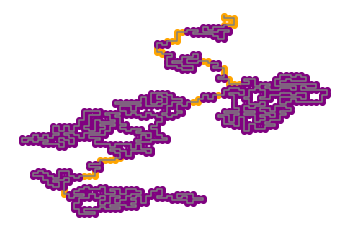

In [17]:
utils.draw_conformation(conformations[0].struct, bridges=br)

In [18]:
c, b, b_s = shape_data(neighbors)

In [19]:
c

array([168,  45,   8, 348,   9, 280,   4,   6,  35,   4,   6,  34])

Find clasters in all conformations

In [20]:
k = 0
clusters = []
bridges = []
for conf in conformations:
    k += 1
    if k % 100 == 0:
        print(k)
    neighbors = utils.tabulate_neighbors(conf.struct)
    c, b, b_s = shape_data(neighbors)
    clusters.append(c)
    bridges.append(b)

100
200
300
400
500
600
700
800
900
1000


In [21]:
clusters[0].shape

(12,)

In [22]:
points = np.empty((len(conformations), 2), dtype=float)
for i in range(len(conformations)):
    points[i] = (conformations[i].R_norm, clusters[i].shape[0])


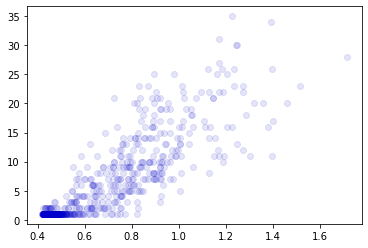

In [23]:
plt.scatter(points[:, 0], points[:, 1], color=(0, 0, 0.8, 0.1) )

In [24]:
k = 0
clusters = []
bridges = []
for conf in conformations:
    k += 1
    if k % 100 == 0:
        print(k)
    neighbors = utils.tabulate_neighbors(conf.struct)
    c, b, b_s = shape_data(neighbors)
    clusters.append(c)
    bridges.append(b)

100
200
300
400
500
600
700
800
900
1000


In [25]:
points = np.empty((len(conformations), 2), dtype=float)
for i in range(len(conformations)):
    points[i] = (conformations[i].R_norm, clusters[i].shape[0])


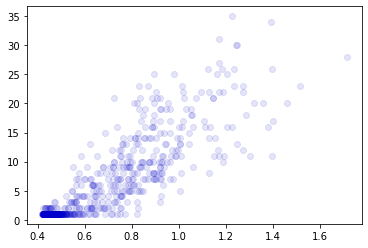

In [26]:
plt.scatter(points[:, 0], points[:, 1], color=(0, 0, 0.8, 0.1));

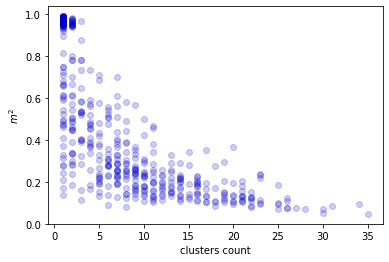

In [27]:
points = np.empty((len(conformations), 2), dtype=float)
for i in range(len(conformations)):
    points[i] = (clusters[i].shape[0], conformations[i].mag2[-1].mean)

plt.xlabel('clusters count')
plt.ylabel('$m^2$')
plt.scatter(points[:, 0], points[:, 1], color=(0, 0, 0.8, 0.2));

92


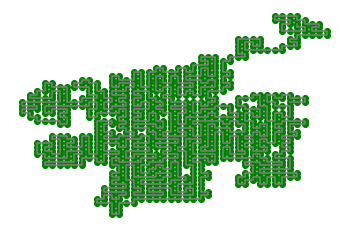

460


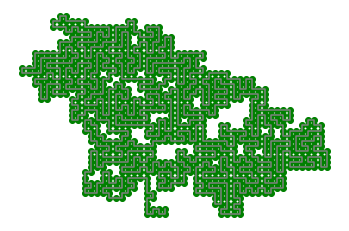

In [28]:
for i in range(len(conformations)):
    if clusters[i].shape[0] > 2 and conformations[i].mag2[-1].mean > 0.8:
        print(i)
        utils.draw_conformation(conformations[i].struct)

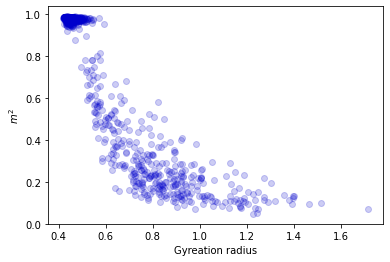

In [29]:
points = np.empty((len(conformations), 2), dtype=float)
for i in range(len(conformations)):
    points[i] = (conformations[i].R_norm, conformations[i].mag2[-1].mean)

plt.xlabel('Gyreation radius')
plt.ylabel('$m^2$')
plt.scatter(points[:, 0], points[:, 1], color=(0, 0, 0.8, 0.2));

#202, R = 0.585089026698224, m^2=0.2982981952866888
clusters: [782 179   4   6   4   4]
bridges: [12  2  1  4  1  2]


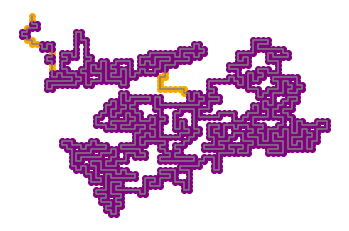

#234, R = 0.5945443467537183, m^2=0.38805877253016197
clusters: [940   4   8  38]
bridges: [1 2 8]


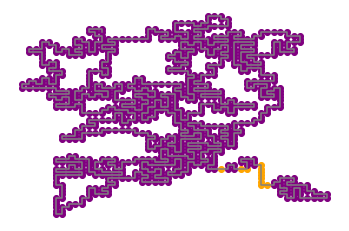

#837, R = 0.5851384788051115, m^2=0.31208643401013253
clusters: [1001]
bridges: []


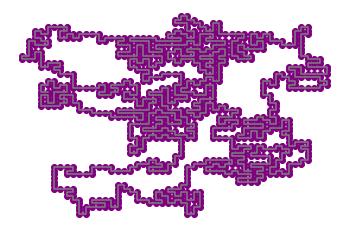

In [30]:
for i in range(len(conformations)):
    if conformations[i].R_norm < 0.6 and  conformations[i].mag2[-1].mean < 0.4:
        print('#{}, R = {}, m^2={}'.format(i, conformations[i].R_norm, conformations[i].mag2[-1].mean))
        print('clusters:', clusters[i])
        print('bridges:', bridges[i])
        _, _, bs = shape_data(utils.tabulate_neighbors(conformations[i].struct))
        utils.draw_conformation(conformations[i].struct, bridges=bs)

As seen in pictures above. Serchig for classic bridges does not achieve the desired result. 

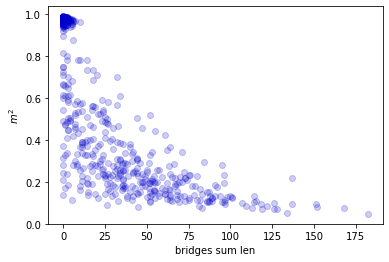

In [31]:
points = np.empty((len(conformations), 2), dtype=float)
for i in range(len(conformations)):
    points[i] = (bridges[i].sum(), conformations[i].mag2[-1].mean)

plt.xlabel('bridges sum len')
plt.ylabel('$m^2$')
plt.scatter(points[:, 0], points[:, 1], color=(0, 0, 0.8, 0.2));

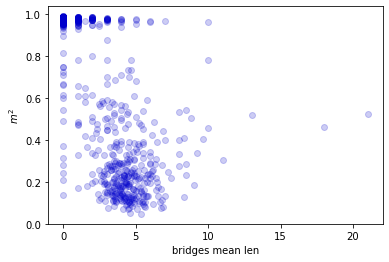

In [32]:
points = np.empty((len(conformations), 2), dtype=float)
for i in range(len(conformations)):
    if bridges[i].shape[0] == 0:
        points[i] = (0, conformations[i].mag2[-1].mean)
    else:
        points[i] = (bridges[i].mean(), conformations[i].mag2[-1].mean)

plt.xlabel('bridges mean len')
plt.ylabel('$m^2$')
plt.scatter(points[:, 0], points[:, 1], color=(0, 0, 0.8, 0.2));

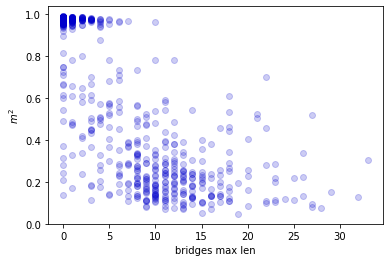

In [33]:
points = np.empty((len(conformations), 2), dtype=float)
for i in range(len(conformations)):
    if bridges[i].shape[0] == 0:
        points[i] = (0, conformations[i].mag2[-1].mean)
    else:
        points[i] = (bridges[i].max(), conformations[i].mag2[-1].mean)

plt.xlabel('bridges max len')
plt.ylabel('$m^2$')
plt.scatter(points[:, 0], points[:, 1], color=(0, 0, 0.8, 0.2));

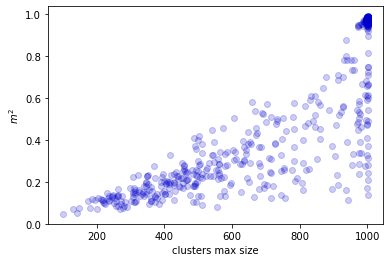

In [34]:
points = np.empty((len(conformations), 2), dtype=float)
for i in range(len(conformations)):
    if clusters[i].shape[0] == 0:
        points[i] = (0, conformations[i].mag2[-1].mean)
    else:
        points[i] = (clusters[i].max(), conformations[i].mag2[-1].mean)

plt.xlabel('clusters max size')
plt.ylabel('$m^2$')
plt.scatter(points[:, 0], points[:, 1], color=(0, 0, 0.8, 0.2));

## Counting 1D segments

In [35]:
@njit()
def find_1D_sigments(neighbors):
    bridges = np.zeros(neighbors.shape[0], np.bool_)
    for i in range(neighbors.shape[0]):
        if neighbors[i, 0] < 3:
            bridges[i] = True
            
    # add spins connecting bridges and clusters to clusters
    bridges_cpy = bridges.copy()
    for i in range(neighbors.shape[0]):
        if bridges_cpy[i]:
            for j in range(1, neighbors[i, 0]+1):
                if not bridges_cpy[neighbors[i, j]]:
                    bridges[i] = False
                    break
    
    return bridges
    
@njit()
def clusters_and_lines(neighbors):
    """
    Calculates number and size of clusters and bridges (1D sigments)
    Bridge - set of connected spins such that if you remove one of them the graph will split into two
    Cluster - set of conected spins that can be removed without splitting graph
    
    Parameters
    ----------
    neighbors: np.array(L, :) int
        list of neighbors
        neighbors[i, 0] = number of neghbors
        
    Returns
    -------
    clusters: np.array(:) int
        sizes of clusters
        
    bridges: np.array(:) int
        sizes of bridges
        
    bridges_spins: np.array(L) bool
        True if spin is in a bridge
    """
    bridges_spins = find_1D_sigments(neighbors)
    
    n = neighbors.shape[0]
    used = np.zeros(n, dtype=np.bool_)
    
    cluster_count = 0
    bridges_count = 0
    clusters = np.zeros(n, dtype=np.int32)
    bridges = np.zeros(n, dtype=np.int32)
    for i in range(n):
        if not used[i]:
            if bridges_spins[i]:
                bridges[bridges_count] = dfs_len_bridges(i, neighbors, used, bridges_spins)
                bridges_count += 1
                
            else:
                clusters[cluster_count] = dfs_size_clusters(i, neighbors, used, bridges_spins)
                cluster_count += 1
    
    clusters = clusters[:cluster_count]
    bridges = bridges[:bridges_count]
    
    return clusters, bridges, bridges_spins

#202, R = 0.585089026698224, m^2=0.2982981952866888
clusters: [782 179   4   6   4   4]
bridges: [12  2  1  4  1  2]


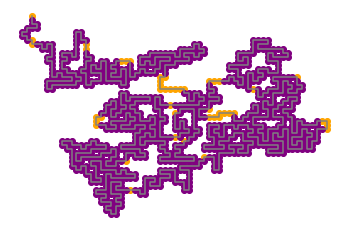

#234, R = 0.5945443467537183, m^2=0.38805877253016197
clusters: [940   4   8  38]
bridges: [1 2 8]


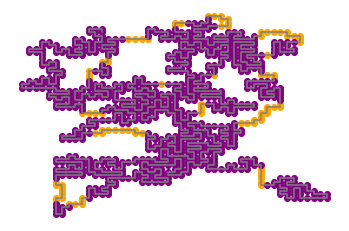

#837, R = 0.5851384788051115, m^2=0.31208643401013253
clusters: [1001]
bridges: []


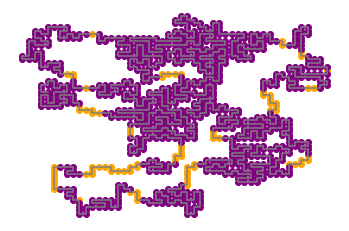

In [36]:
for i in range(len(conformations)):
    if conformations[i].R_norm < 0.6 and  conformations[i].mag2[-1].mean < 0.4:
        print('#{}, R = {}, m^2={}'.format(i, conformations[i].R_norm, conformations[i].mag2[-1].mean))
        print('clusters:', clusters[i])
        print('bridges:', bridges[i])
        _, _, bs = clusters_and_lines(utils.tabulate_neighbors(conformations[i].struct))
        utils.draw_conformation(conformations[i].struct, bridges=bs)

In [42]:
def clusters_and_lines_from_list(conformations):
    k = 0
    clusters = []
    bridges = []
    for conf in conformations:
        k += 1
        if k % 100 == 0:
            print(k)
        neighbors = utils.tabulate_neighbors(conf.struct)
        c, b, b_s = clusters_and_lines(neighbors)
        clusters.append(c)
        bridges.append(b)
        
    return clusters, bridges

In [37]:
clusters, bridges = clusters_and_lines_from_list(conformations)

100
200
300
400
500
600
700
800
900
1000


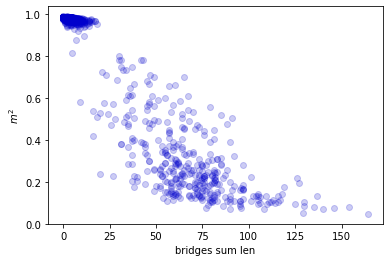

In [38]:
points = np.empty((len(conformations), 2), dtype=float)
for i in range(len(conformations)):
    points[i] = (bridges[i].sum(), conformations[i].mag2[-1].mean)

plt.xlabel('bridges sum len')
plt.ylabel('$m^2$')
plt.scatter(points[:, 0], points[:, 1], color=(0, 0, 0.8, 0.2));

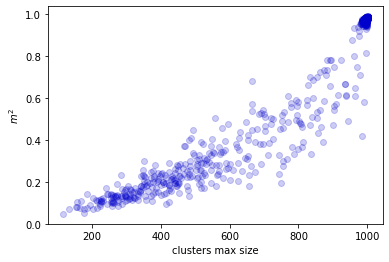

In [39]:
points = np.empty((len(conformations), 2), dtype=float)
for i in range(len(conformations)):
    if clusters[i].shape[0] == 0:
        points[i] = (0, conformations[i].mag2[-1].mean)
    else:
        points[i] = (clusters[i].max(), conformations[i].mag2[-1].mean)

plt.xlabel('clusters max size')
plt.ylabel('$m^2$')
plt.scatter(points[:, 0], points[:, 1], color=(0, 0, 0.8, 0.2));

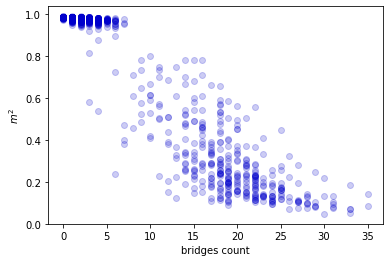

In [40]:
points = np.empty((len(conformations), 2), dtype=float)
for i in range(len(conformations)):
    points[i] = (bridges[i].shape[0], conformations[i].mag2[-1].mean)

plt.xlabel('bridges count')
plt.ylabel('$m^2$')
plt.scatter(points[:, 0], points[:, 1], color=(0, 0, 0.8, 0.2));

## Cluster statistics

In [41]:
conformations = utils.load_Conformations_from_dir('Conformations/L1000_beta0.1_1_10(10000)', load_data=False)

In [43]:
clusters, bridges = clusters_and_lines_from_list(conformations)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000


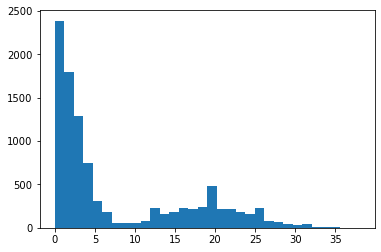

In [50]:
bridges_count = [b.shape[0] for b in bridges]
plt.hist(bridges_count, bins='auto')
plt.show()

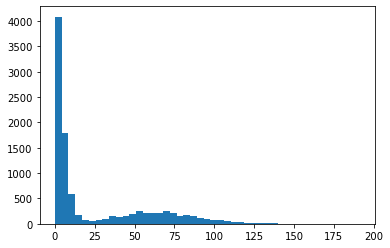

In [52]:
bridges_len = [b.sum() for b in bridges]
plt.hist(bridges_len, bins='auto')
plt.show()

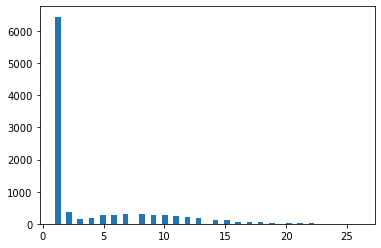

In [58]:
clusters_count = [c.shape[0] for c in clusters]
plt.hist(clusters_count, bins='auto')
plt.show()

In [ ]:
clusters_size = [c.shape[0] for c in clusters]
plt.hist(clusters_size, bins='auto')
plt.show()